In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

### 1. Load Data

In [ ]:
project_root = Path("C://Users//DELL//Desktop//the-year-25-26//scalable-graph-based-movie-recommender")

In [3]:
movies = pd.read_csv(project_root / 'data' / 'processed' / 'movies_gnn.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv(project_root / 'data' / 'processed' / 'ratings_gnn.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [5]:
tags = pd.read_csv(project_root / 'data' / 'processed' / 'tags_gnn.csv')
tags.head()

,userId,movieId,tag,timestamp
0,302,3863,atmospheric,1476691609
1,302,3863,beautiful cinematography,1476691614
2,302,3863,stylized,1476691602
3,302,4226,great ending,1476691644
4,302,4226,psychological,1476691635


In [6]:
genome_scores= pd.read_csv(project_root / 'data' / 'processed' / 'genome_scores_gnn.csv')
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300


In [7]:
genome_tags= pd.read_csv(project_root / 'data' / 'processed' / 'genome_tags_gnn.csv')
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


### 2. EDA

In [8]:
print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)
print("Tags shape:", tags.shape)
print("Genome Tags shape:", genome_tags.shape)
print("Genome Scores shape:", genome_scores.shape)

Ratings shape: (2609897, 4)
Movies shape: (5979, 3)
Tags shape: (487354, 4)
Genome Tags shape: (1128, 2)
Genome Scores shape: (6744312, 3)


In [9]:
# Check for missing values
print("\n=== DATA QUALITY ===\n")
print("Missing values:")
print(f"  Ratings: {ratings.isnull().sum().sum()}")
print(f"  Movies: {movies.isnull().sum().sum()}")
print(f"  Tags: {tags.isnull().sum().sum()}")
print(f"  Genome Scores: {genome_scores.isnull().sum().sum()}")


=== DATA QUALITY ===

Missing values:
  Ratings: 0
  Movies: 0
  Tags: 0
  Genome Scores: 0


### 2.1. Movies & Ratings Data

In [10]:
# Check rating distribution
print(f"\nRating distribution:")
print(ratings['rating'].value_counts().sort_index())


Rating distribution:
rating
0.5     38780
1.0     74857
1.5     41301
2.0    161967
2.5    131138
3.0    491458
3.5    348539
4.0    694069
4.5    244972
5.0    382816
Name: count, dtype: int64


### What is the distribution of movie ratings?

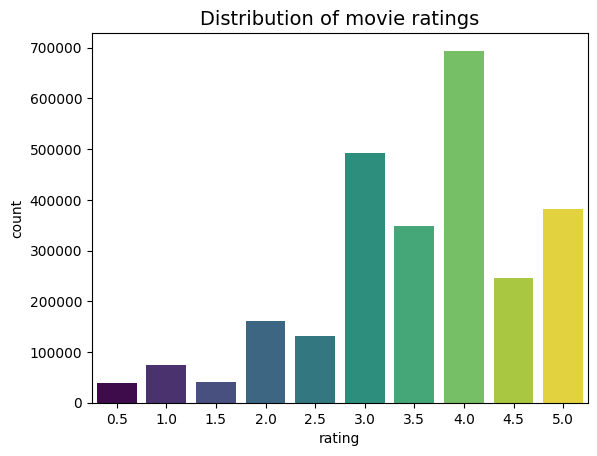

In [11]:
sns.countplot(data=ratings, x="rating", hue="rating", palette="viridis", legend=False)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [12]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.56.
Mean rating per user: 3.71.


### Movie Popularity

In [13]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Forrest Gump (1994)                                          8371
Shawshank Redemption, The (1994)                             8274
Pulp Fiction (1994)                                          8250
Matrix, The (1999)                                           7871
Silence of the Lambs, The (1991)                             7496
Star Wars: Episode IV - A New Hope (1977)                    7168
Jurassic Park (1993)                                         6497
Fight Club (1999)                                            6427
Star Wars: Episode V - The Empire Strikes Back (1980)        6256
Lord of the Rings: The Fellowship of the Ring, The (2001)    6185
Name: count, dtype: int64

### What are the lowest and highest rated movies? 

In [14]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
2760,4775,Glitter (2001),Drama|Musical|Romance


`Glitter (2001)` has the lowest average rating.

In [15]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
5542,159817,Planet Earth (2006),Documentary


In [16]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
23312,3090,159817,5.0,1587590807
28881,4062,159817,4.0,1514687997
67125,9401,159817,4.0,1496361599
90551,12556,159817,5.0,1586390143
97689,13267,159817,4.5,1570449942
...,...,...,...,...
2566954,326512,159817,5.0,1573940908
2574274,327475,159817,4.0,1477793588
2586278,328838,159817,5.0,1487207511
2591282,329700,159817,4.5,1610779852


`Planet Earth (2006)` has the highest average rating, but it has 282 ratings. A better approach for evaluating movie popularity is to look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

### Bayesian Average

This is an approach utilize by IMDb. It essentially “pulls” the rating towards a predetermined mean. This is crucial for movies with few ratings, preventing a small group of extreme opinions from unduly influencing the score.

In [17]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,5819,3.890273
2,2520,3.263294
3,1004,3.125000
4,248,2.860887
5,1058,3.023157


In [18]:
C = movie_stats['count'].mean()
C

np.float64(436.5106205051012)

In [19]:
m = movie_stats['mean'].mean()
m

np.float64(3.3480792379175237)

In [20]:
print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

Average number of ratings for a given movie: 436.51
Average rating for a given movie: 3.35


In [21]:
def bayesian_avg(ratings, C=436.51, m=3.35):
    R = ratings.mean()
    v = ratings.count()
    bayes = (v/(v + C)) * R + (C/(v + C)) * m
    return round(float(bayes), 3)

In [22]:
planet_earth = pd.Series([5.0, 5.0])
bayesian_avg(planet_earth, C, m)

3.356

`Planet Earth's` average Bayesian rating is approx. 3.36. 

Let's now apply `bayesian_avg` to all movies in our dataset.

In [23]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [24]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
248,318,8274,4.397450,4.345,"Shawshank Redemption, The (1994)"
578,858,5565,4.300988,4.232,"Godfather, The (1972)"
46,50,5793,4.251079,4.188,"Usual Suspects, The (1995)"
414,527,6169,4.232858,4.175,Schindler's List (1993)
1902,2959,6427,4.223277,4.168,Fight Club (1999)


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `The Usual Suspects` are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

In [25]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
2239,3593,420,1.589286,2.487,Battlefield Earth (2000)
1016,1562,1024,2.145020,2.505,Batman & Robin (1997)
1015,1556,520,1.901923,2.563,Speed 2: Cruise Control (1997)
997,1499,617,2.042139,2.584,Anaconda (1997)
1742,2701,1192,2.317114,2.594,Wild Wild West (1999)


With Bayesian averaging, it looks  `Battlefield Earth`, `Batman & Robin`, and `Speed 2: Cruise Control` are the worst rated movies.

### - Genre

In [26]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


**How many movie genres are there?**

In [27]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 2759,
         'Comedy': 2205,
         'Thriller': 1426,
         'Action': 1329,
         'Romance': 1040,
         'Adventure': 938,
         'Crime': 823,
         'Sci-Fi': 710,
         'Horror': 607,
         'Fantasy': 553,
         'Children': 456,
         'Mystery': 421,
         'Animation': 325,
         'War': 246,
         'Musical': 198,
         'Documentary': 142,
         'IMAX': 141,
         'Western': 106,
         'Film-Noir': 53,
         '(no genres listed)': 12})

In [28]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 2759), ('Comedy', 2205), ('Thriller', 1426), ('Action', 1329), ('Romance', 1040)]


The top 5 genres are: `Drama`, `Comedy`, `Thriller`, `Action` and `Romance`.

Let's also visualize genres popularity with a barplot.

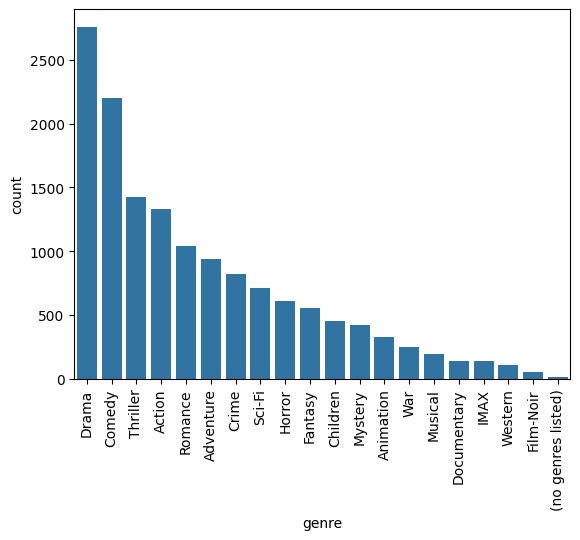

In [29]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

### - Sparsity Check

In [30]:
# Compute activity levels
user_activity = ratings.groupby("userId").size()
movie_popularity = ratings.groupby("movieId").size()

# Sort for binning
sorted_users = user_activity.sort_values()
sorted_movies = movie_popularity.sort_values()

# Map users and movies to bins
NUM_BINS = 100

user_bins = pd.qcut(sorted_users.rank(method="first"), NUM_BINS, labels=False)
movie_bins = pd.qcut(sorted_movies.rank(method="first"), NUM_BINS, labels=False)

# Create lookup tables
user_bin_map = dict(zip(sorted_users.index, user_bins))
movie_bin_map = dict(zip(sorted_movies.index, movie_bins))

# Assign each rating into a (user_bin, movie_bin)
ratings["user_bin"] = ratings["userId"].map(user_bin_map)
ratings["movie_bin"] = ratings["movieId"].map(movie_bin_map)

In [31]:
# Compute heatmap matrix
heatmap_matrix = ratings.groupby(["user_bin", "movie_bin"]).size().unstack(fill_value=0)

In [32]:
# Convert to log scale for visibility
heatmap_log = np.log1p(heatmap_matrix)
heatmap_log

movie_bin,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_bin,,,,,,,,,,,,,,,,,,,,,
0,2.079442,2.302585,2.484907,2.484907,1.945910,2.397895,2.302585,2.302585,1.098612,1.945910,...,4.615121,4.564348,4.510860,4.624973,4.882802,5.105945,5.198497,5.231109,5.676754,6.467699
1,1.098612,1.098612,1.098612,1.098612,1.791759,1.609438,1.386294,1.386294,0.693147,1.609438,...,4.532599,4.521789,4.875197,5.105945,5.062595,5.521461,5.545177,5.736572,6.107023,6.980076
2,1.098612,1.098612,1.386294,1.098612,1.609438,0.693147,0.000000,1.791759,1.098612,1.945910,...,4.770685,4.727388,4.905275,5.043425,5.123964,5.416100,5.575949,5.831882,6.196444,7.036148
3,1.609438,0.000000,0.000000,0.000000,1.098612,1.386294,0.693147,1.098612,1.098612,1.386294,...,4.382027,4.521789,4.875197,5.220356,4.997212,5.411646,5.602119,5.852202,6.159095,7.028201
4,1.098612,0.693147,1.098612,1.609438,1.098612,1.386294,1.386294,0.000000,1.098612,1.609438,...,4.543295,4.700480,4.828314,4.983607,4.983607,5.480639,5.616771,5.786897,6.261492,7.126891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.997212,4.905275,4.762174,5.129899,5.010635,5.036953,5.049856,5.135798,5.056246,5.049856,...,7.807510,7.961719,8.001020,8.025843,8.145550,8.134468,8.311890,8.446341,8.590630,8.806873
96,5.135798,5.204007,5.241747,5.252273,5.170484,5.283204,5.164786,5.220356,5.225747,5.252273,...,7.912789,8.069655,8.098035,8.150468,8.244334,8.220672,8.378391,8.507547,8.649449,8.863050
97,5.480639,5.446737,5.459586,5.455321,5.370638,5.493061,5.556828,5.501258,5.537334,5.575949,...,8.053251,8.158516,8.190909,8.232440,8.324336,8.321422,8.459352,8.591558,8.712595,8.891236


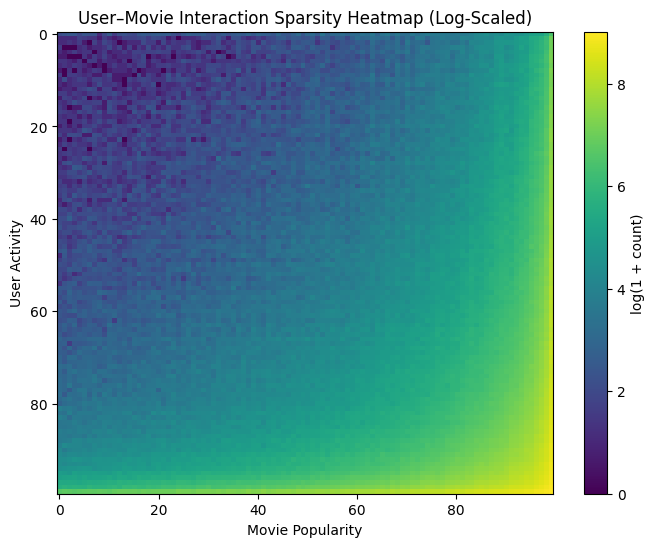

In [34]:
# Plot heatmap

plt.figure(figsize=(8, 6))
plt.imshow(heatmap_log, cmap="viridis", aspect="auto")
plt.title("User–Movie Interaction Sparsity Heatmap (Log-Scaled)")
plt.xlabel("Movie Popularity")
plt.ylabel("User Activity")
plt.colorbar(label="log(1 + count)")
plt.savefig('../docs/users_movies_interaction.png', dpi=300)
plt.show()

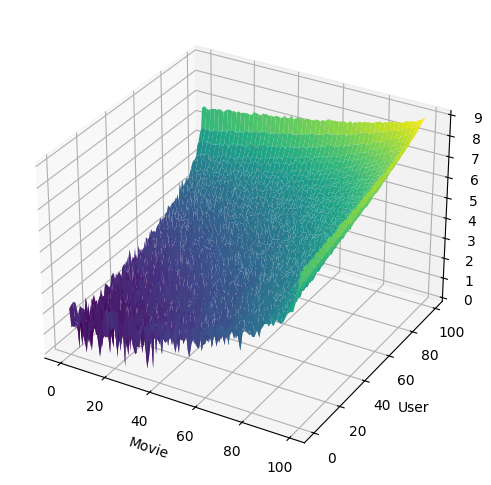

In [34]:
# 3D Surface Plot 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(range(heatmap_matrix.shape[1]), range(heatmap_matrix.shape[0]))
ax.plot_surface(x, y, heatmap_log.values, cmap='viridis')
ax.set_xlabel('Movie')
ax.set_ylabel('User')
ax.set_zlabel('log(count)')
plt.savefig('../docs/users_movies_surface_plot.png', dpi=300)
plt.show()

In [42]:
# Sparsity
sparsity = 1 - (len(ratings) / (ratings['userId'].nunique() * ratings['movieId'].nunique()))
print(f"\nMatrix sparsity: {sparsity:.2%}")


Matrix sparsity: 97.09%


- 97.09% of the user-movie interaction matrix is empty. For every 100 possible slots (one for each unique user-movie pair), only about 2.91 have a recorded rating or interaction.

- This is a very high level of sparsity.  It highlights the `"cold start" problem` that most users haven't rated most movies, making it challenging to find similar users or items for accurate predictions.

### 2.2. Tags Data

In [43]:
from collections import Counter

In [44]:
# Tagging activity
tags_per_user = tags.groupby('userId').size()
tags_per_movie = tags.groupby('movieId').size()

print(f"\n>>> Activity Distribution:")
print(f"  Avg tags per user: {tags_per_user.mean():.2f}")
print(f"  Median tags per user: {tags_per_user.median():.0f}")
print(f"  Max tags by one user: {tags_per_user.max():,}")
print(f"  Avg tags per movie: {tags_per_movie.mean():.2f}")
print(f"  Median tags per movie: {tags_per_movie.median():.0f}")
print(f"  Max tags on one movie: {tags_per_movie.max():,}")
    


>>> Activity Distribution:
  Avg tags per user: 330.86
  Median tags per user: 6
  Max tags by one user: 365,284
  Avg tags per movie: 82.14
  Median tags per movie: 22
  Max tags on one movie: 1,254


In [45]:
# Most active taggers
print(f"\n>>> Top 10 Most Active Taggers:")
top_taggers = tags_per_user.nlargest(10)
for i, (user_id, count) in enumerate(top_taggers.items(), 1):
   print(f"  {i:2d}. User {user_id}: {count:,} tags")


>>> Top 10 Most Active Taggers:
   1. User 215490: 365,284 tags
   2. User 10730: 9,887 tags
   3. User 222223: 7,077 tags
   4. User 99118: 5,996 tags
   5. User 151122: 5,430 tags
   6. User 160234: 4,199 tags
   7. User 316671: 3,930 tags
   8. User 48766: 3,382 tags
   9. User 274406: 3,204 tags
  10. User 322237: 1,932 tags


In [46]:
# Most tagged movies
print(f"\n>>> Top 10 Most Tagged Movies:")
top_tagged = tags_per_movie.nlargest(10)
for i, (movie_id, count) in enumerate(top_tagged.items(), 1):
    movie_title = movies[movies['movieId'] == movie_id]['title'].values
    title = movie_title[0] if len(movie_title) > 0 else "Unknown"
    print(f"{i:2d}. {title[:50]}: {count:,} tags")


>>> Top 10 Most Tagged Movies:
 1. Pulp Fiction (1994): 1,254 tags
 2. Star Wars: Episode IV - A New Hope (1977): 1,088 tags
 3. Fight Club (1999): 990 tags
 4. Avengers: Infinity War - Part II (2019): 962 tags
 5. Matrix, The (1999): 957 tags
 6. Avengers: Infinity War - Part I (2018): 907 tags
 7. The Batman (2022): 886 tags
 8. Guardians of the Galaxy 2 (2017): 853 tags
 9. Wonder Woman (2017): 850 tags
10. Black Panther (2017): 844 tags


In [47]:
# Tag vocabulary
print(f"\n >>> Tag Vocabulary:")
tag_counts = tags['tag'].value_counts()
print(f"  Most common tags:")
for i, (tag, count) in enumerate(tag_counts.head(20).items(), 1):
  print(f"  {i:2d}. '{tag}': {count:,} times")


 >>> Tag Vocabulary:
  Most common tags:
   1. 'sci-fi': 1,242 times
   2. 'violence': 1,222 times
   3. 'atmospheric': 1,200 times
   4. 'murder': 1,183 times
   5. 'cult film': 997 times
   6. 'action': 876 times
   7. 'comedy': 873 times
   8. 'death': 859 times
   9. 'friendship': 843 times
  10. 'dark comedy': 800 times
  11. 'visually appealing': 760 times
  12. 'revenge': 754 times
  13. 'surreal': 748 times
  14. 'dystopia': 740 times
  15. 'funny': 712 times
  16. 'black comedy': 694 times
  17. 'suspense': 692 times
  18. 'twist ending': 659 times
  19. 'blood': 648 times
  20. 'thought-provoking': 633 times


In [48]:
# Tag length analysis
tag_lengths = tags['tag'].str.len()
print(f"\n>>> Tag Length Statistics:")
print(f"  Avg length: {tag_lengths.mean():.2f} characters")
print(f"  Median length: {tag_lengths.median():.0f} characters")
print(f"  Min length: {tag_lengths.min()}")
print(f"  Max length: {tag_lengths.max()}")


>>> Tag Length Statistics:
  Avg length: 11.78 characters
  Median length: 11 characters
  Min length: 1
  Max length: 230


In [49]:
# Multi-word tags
multi_word = tags['tag'].str.split().str.len() > 1
print(f"  Single-word tags: {(~multi_word).sum():,} ({(~multi_word).mean()*100:.1f}%)")
print(f"  Multi-word tags: {multi_word.sum():,} ({multi_word.mean()*100:.1f}%)")

  Single-word tags: 232,256 (47.7%)
  Multi-word tags: 255,098 (52.3%)


In [50]:
# Temporal analysis
tags['datetime'] = pd.to_datetime(tags['timestamp'], unit='s')
print(f"\n Temporal Coverage:")
print(f"  First tag: {tags['datetime'].min()}")
print(f"  Last tag: {tags['datetime'].max()}")
print(f"  Span: {(tags['datetime'].max() - tags['datetime'].min()).days} days")


 Temporal Coverage:
  First tag: 2006-01-03 19:30:13
  Last tag: 2023-07-20 00:29:36
  Span: 6406 days


In [51]:
# Tags per year
tags_per_year = tags.groupby(tags['datetime'].dt.year).size()
print(f"\n  Tags per year:")
for year, count in tags_per_year.items():
  print(f"    {year}: {count:,} tags")


  Tags per year:
    2006: 2,596 tags
    2007: 1,072 tags
    2008: 765 tags
    2009: 6,054 tags
    2010: 2,975 tags
    2011: 6,281 tags
    2012: 3,192 tags
    2013: 3,475 tags
    2014: 2,473 tags
    2015: 11,071 tags
    2016: 7,074 tags
    2017: 7,773 tags
    2018: 60,932 tags
    2019: 14,104 tags
    2020: 13,726 tags
    2021: 268,255 tags
    2022: 71,994 tags
    2023: 3,542 tags


 ### 2.3. Genome Score

In [52]:
# Relevance score distribution
print(f"\n Relevance Score Distribution:")
print(f"  Mean: {genome_scores['relevance'].mean():.4f}")
print(f"  Median: {genome_scores['relevance'].median():.4f}")
print(f"  Std: {genome_scores['relevance'].std():.4f}")
print(f"  Min: {genome_scores['relevance'].min():.4f}")
print(f"  Max: {genome_scores['relevance'].max():.4f}")


 Relevance Score Distribution:
  Mean: 0.1217
  Median: 0.0573
  Std: 0.1644
  Min: 0.0005
  Max: 1.0000


In [53]:
# Percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print(f"\n  Percentiles:")
for p in percentiles:
  val = genome_scores['relevance'].quantile(p/100)
  print(f"    {p}th: {val:.4f}")


  Percentiles:
    25th: 0.0242
    50th: 0.0573
    75th: 0.1452
    90th: 0.3160
    95th: 0.4825
    99th: 0.8277


In [54]:
 # High relevance scores
high_relevance = (genome_scores['relevance'] > 0.5).sum()
print(f"\n  Scores > 0.5: {high_relevance:,} ({high_relevance/len(genome_scores)*100:.2f}%)")
print(f"  Scores > 0.7: {(genome_scores['relevance'] > 0.7).sum():,}")
print(f"  Scores > 0.9: {(genome_scores['relevance'] > 0.9).sum():,}")
    


  Scores > 0.5: 314,368 (4.66%)
  Scores > 0.7: 136,150
  Scores > 0.9: 37,654


In [55]:
# Coverage analysis
scores_per_movie = genome_scores.groupby('movieId').size()
expected_scores = genome_tags.shape[0]
print(f"\n >>> Coverage Analysis:")
print(f"  Expected scores per movie: {expected_scores}")
print(f"  Actual avg scores per movie: {scores_per_movie.mean():.1f}")
print(f"  Movies with full coverage: {(scores_per_movie == expected_scores).sum():,}")
    


 >>> Coverage Analysis:
  Expected scores per movie: 1128
  Actual avg scores per movie: 1128.0
  Movies with full coverage: 5,979


In [56]:
# Most distinctive tags (high variance)
tag_variance = genome_scores.groupby('tagId')['relevance'].var().sort_values(ascending=False)
print(f"\n >>> Most Distinctive Tags (high variance):")
for i, (tag_id, variance) in enumerate(tag_variance.head(10).items(), 1):
  tag_name = genome_tags[genome_tags['tagId'] == tag_id]['tag'].values[0]
  print(f"  {i:2d}. '{tag_name}': variance={variance:.4f}")


 >>> Most Distinctive Tags (high variance):
   1. 'comedy': variance=0.0993
   2. 'action': variance=0.0890
   3. 'tense': variance=0.0728
   4. 'violence': variance=0.0684
   5. 'drama': variance=0.0669
   6. 'funny': variance=0.0662
   7. 'based on a book': variance=0.0629
   8. 'dramatic': variance=0.0578
   9. 'horror': variance=0.0567
  10. 'relationships': variance=0.0566


In [57]:
# Most common tags (high mean relevance)
tag_means = genome_scores.groupby('tagId')['relevance'].mean().sort_values(ascending=False)
print(f"\n>>> Most Prevalent Tags (high mean relevance):")
for i, (tag_id, mean_rel) in enumerate(tag_means.head(10).items(), 1):
  tag_name = genome_tags[genome_tags['tagId'] == tag_id]['tag'].values[0]
  print(f"  {i:2d}. '{tag_name}': mean={mean_rel:.4f}")


>>> Most Prevalent Tags (high mean relevance):
   1. 'original': mean=0.7421
   2. 'mentor': mean=0.5634
   3. 'storytelling': mean=0.5280
   4. 'catastrophe': mean=0.4972
   5. 'great ending': mean=0.4892
   6. 'dialogue': mean=0.4803
   7. 'good': mean=0.4764
   8. 'good soundtrack': mean=0.4732
   9. 'runaway': mean=0.4435
  10. 'great': mean=0.4425


### 2.4. Genome Tag Vocabs

In [58]:
# Tag categories (by pattern)
tag_text = genome_tags['tag'].str.lower()
tag_text[0:10]

0             007
1    007 (series)
2    18th century
3           1920s
4           1930s
5           1950s
6           1960s
7           1970s
8           1980s
9    19th century
Name: tag, dtype: object

In [59]:
   # Detect categories
categories = {
        'Decades': tag_text.str.contains(r'\d{4}s$', regex=True).sum(),
        'Centuries': tag_text.str.contains(r'\d+th century', regex=True).sum(),
        'Genres': tag_text.str.contains('|'.join([
            'action', 'comedy', 'drama', 'horror', 'romance', 'thriller', 
            'sci-fi', 'fantasy', 'animation'
        ]), regex=False).sum(),
        'Emotions': tag_text.str.contains('|'.join([
            'funny', 'sad', 'dark', 'happy', 'depressing', 'suspenseful'
        ]), regex=False).sum(),
        'Franchises': tag_text.str.contains(r'\(series\)', regex=True).sum(),
    }
print(f"\n  Tag Categories (detected patterns):")
for category, count in categories.items():
  print(f"  {category}: {count}")


  Tag Categories (detected patterns):
  Decades: 6
  Centuries: 2
  Genres: 0
  Emotions: 0
  Franchises: 1


In [60]:
  # Tag length
tag_lengths = genome_tags['tag'].str.len()
print(f"\n Tag Length:")
print(f"  Avg: {tag_lengths.mean():.2f} characters")
print(f"  Median: {tag_lengths.median():.0f}")
print(f"  Min: {tag_lengths.min()}")
print(f"  Max: {tag_lengths.max()}")


 Tag Length:
  Avg: 10.02 characters
  Median: 9
  Min: 2
  Max: 65


In [61]:
user_tags_clean = tags['tag'].str.lower().str.strip()
genome_tags_clean = genome_tags['tag'].str.lower().str.strip()
    
# Overlap
user_unique = set(user_tags_clean.unique())
genome_unique = set(genome_tags_clean.unique())
    
overlap = user_unique.intersection(genome_unique)
    
print(f"\n Tag System Overlap:")
print(f"  Unique user tags: {len(user_unique):,}")
print(f"  Unique genome tags: {len(genome_unique):,}")
print(f"  Tags in both systems: {len(overlap):,}")
print(f"  Overlap percentage: {len(overlap)/len(genome_unique)*100:.2f}% of genome tags")


 Tag System Overlap:
  Unique user tags: 70,409
  Unique genome tags: 1,128
  Tags in both systems: 1,119
  Overlap percentage: 99.20% of genome tags


In [62]:
# Show overlapping tags
if len(overlap) > 0:
  print(f"\n  20 overlapping tags:")
  for tag in list(overlap)[:20]:
    user_count = (user_tags_clean == tag).sum()
    print(f"    '{tag}': used {user_count:,} times by users")


  20 overlapping tags:
    'good action': used 6 times by users
    'cute!': used 6 times by users
    'dog': used 500 times by users
    'good music': used 23 times by users
    'enigmatic': used 48 times by users
    'hotel': used 301 times by users
    'prison escape': used 78 times by users
    'time loop': used 125 times by users
    'fake documentary': used 17 times by users
    'poignant': used 38 times by users
    'view askew': used 22 times by users
    'germany': used 66 times by users
    'robot': used 156 times by users
    'comics': used 13 times by users
    'interracial romance': used 38 times by users
    'plot holes': used 95 times by users
    'drugs': used 464 times by users
    'amazing photography': used 15 times by users
    'doctors': used 3 times by users
    'heroine in tight suit': used 15 times by users


In [63]:
# User tags not in genome
user_only = user_unique - genome_unique
print(f"\n  Most common user tags NOT in genome:")
user_tag_counts = tags['tag'].str.lower().value_counts()
user_only_counts = user_tag_counts[user_tag_counts.index.isin(user_only)]
for i, (tag, count) in enumerate(user_only_counts.head(20).items(), 1):
  print(f"  {i:2d}. '{tag}': {count:,} times")
    


  Most common user tags NOT in genome:
   1. 'flashback': 553 times
   2. 'explosion': 524 times
   3. 'husband wife relationship': 519 times
   4. 'title spoken by character': 484 times
   5. 'fight': 482 times
   6. 'kiss': 480 times
   7. 'escape': 462 times
   8. 'bare chested male': 456 times
   9. 'psychotronic film': 453 times
  10. 'based on novel or book': 450 times
  11. 'cigarette smoking': 440 times
  12. 'pistol': 438 times
  13. 'gun': 433 times
  14. 'mother son relationship': 433 times
  15. 'deception': 412 times
  16. 'fire': 406 times
  17. 'corpse': 398 times
  18. 'rescue': 397 times
  19. 'female nudity': 391 times
  20. 'knife': 383 times


In [64]:
# Merge tags with ratings
movie_rating_stats = ratings.groupby('movieId').agg({
        'rating': ['mean', 'count']
    }).reset_index()
movie_rating_stats.columns = ['movieId', 'avg_rating', 'num_ratings']
    
tags_with_ratings = tags.merge(
        movie_rating_stats,
        on='movieId',
        how='left'
    )
    
print(f"\n >>> Tagged Movies vs All Movies:")
tagged_movies = tags['movieId'].unique()
all_movies = ratings['movieId'].unique()
print(f"  Movies with user tags: {len(tagged_movies):,}")
print(f"  Total movies in dataset: {len(all_movies):,}")
print(f"  Coverage: {len(tagged_movies)/len(all_movies)*100:.2f}%")
    


 >>> Tagged Movies vs All Movies:
  Movies with user tags: 5,933
  Total movies in dataset: 5,979
  Coverage: 99.23%


In [65]:
# Rating distribution for tagged vs non-tagged
tagged_ratings = ratings[ratings['movieId'].isin(tagged_movies)]['rating'].mean()
all_ratings = ratings['rating'].mean()
    
print(f"\n>>> Rating Comparison:")
print(f"  Avg rating (tagged movies): {tagged_ratings:.3f}")
print(f"  Avg rating (all movies): {all_ratings:.3f}")
print(f"  Difference: {tagged_ratings - all_ratings:+.3f}")


>>> Rating Comparison:
  Avg rating (tagged movies): 3.562
  Avg rating (all movies): 3.561
  Difference: +0.001


In [66]:
# Most tagged movies tend to be...
tags_per_movie_with_rating = tags_with_ratings.groupby('movieId').agg({
        'tag': 'count',
        'avg_rating': 'first',
        'num_ratings': 'first'
    }).reset_index()
tags_per_movie_with_rating.columns = ['movieId', 'num_tags', 'avg_rating', 'num_ratings']

In [67]:
# Top-rated tagged movies
print(f"\n >>> Highest-Rated Tagged Movies:")
top_rated_tagged = tags_per_movie_with_rating.nlargest(10, 'avg_rating')
for i, row in top_rated_tagged.iterrows():
  movie_title = movies[movies['movieId'] == row['movieId']]['title'].values
  title = movie_title[0] if len(movie_title) > 0 else "Unknown"
  print(f"  {title[:50]}: {row['avg_rating']:.2f}star ({int(row['num_tags'])} tags)")


 >>> Highest-Rated Tagged Movies:
  Planet Earth (2006): 4.50star (10 tags)
  Planet Earth II (2016): 4.49star (13 tags)
  Twin Peaks (1989): 4.44star (91 tags)
  Blue Planet II (2017): 4.42star (22 tags)
  Shawshank Redemption, The (1994): 4.40star (823 tags)
  Band of Brothers (2001): 4.38star (106 tags)
  Godfather, The (1972): 4.30star (549 tags)
  12 Angry Men (1957): 4.29star (290 tags)
  Cosmos: 4.29star (125 tags)
  Whiplash (2013): 4.27star (5 tags)


In [69]:

from wordcloud import WordCloud
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')


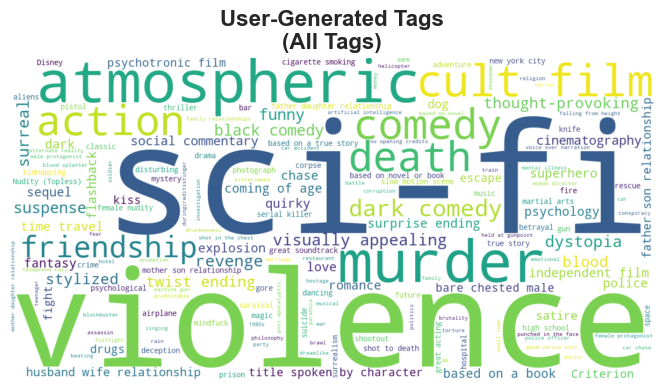

In [70]:
plt.style.use('seaborn-v0_8-darkgrid')

# User-Generated Tags (All)

plt.figure(figsize=(8, 4))
tag_freq = tags['tag'].value_counts().to_dict()
wordcloud1 = WordCloud(width=1200, height=600, background_color='white',
                       colormap='viridis', max_words=200, relative_scaling=0.5,
                       min_font_size=10).generate_from_frequencies(tag_freq)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title('User-Generated Tags\n(All Tags)', fontsize=16, fontweight='bold')
plt.tight_layout()
# plt.savefig('user_generated_tags.png', dpi=300)
plt.show()

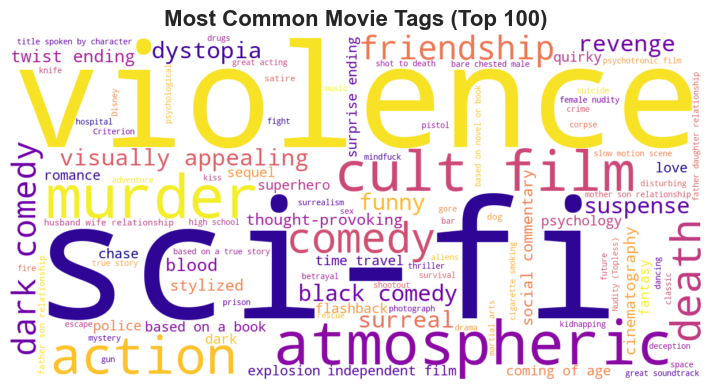

In [71]:
# Most Common Movie Tags (Top 100)
plt.figure(figsize=(8, 4))
top_movie_tags_freq = tags['tag'].value_counts().head(100).to_dict()
wordcloud2 = WordCloud(width=1200, height=600, background_color='white',
                       colormap='plasma', max_words=100, relative_scaling=0.5,
                       min_font_size=10).generate_from_frequencies(top_movie_tags_freq)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Movie Tags (Top 100)', fontsize=16, fontweight='bold')
plt.tight_layout()
# plt.savefig('top_movie_tags.png', dpi=300)
plt.show()

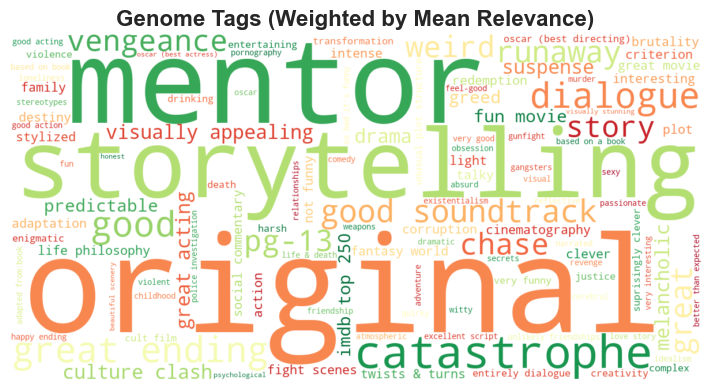

In [72]:
# Genome Tags (Weighted by Mean Relevance)

plt.figure(figsize=(8, 4))
tag_mean_relevance = genome_scores.groupby('tagId')['relevance'].mean()
genome_tag_weights = {genome_tags.loc[genome_tags['tagId']==tag_id, 'tag'].values[0]: rel
                      for tag_id, rel in tag_mean_relevance.items()}
wordcloud3 = WordCloud(width=1200, height=600, background_color='white',
                       colormap='RdYlGn', max_words=150, relative_scaling=0.5,
                       min_font_size=10).generate_from_frequencies(genome_tag_weights)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis('off')
plt.title('Genome Tags (Weighted by Mean Relevance)', fontsize=16, fontweight='bold')
plt.tight_layout()
# plt.savefig('genome_tags.png', dpi=300)
plt.show()